**ส่วนนี้คือการทำ data cleaning (ท่านสามารถดูเพิ่มเติมได้ที่ 1_Data_Cleaning.ipynb)**

**สำหรับการลดขนาดมิติข้อมูลด้วยเทคนิค Linear Discriminant Analysis (LDA) จะเริ่มต่อท้ายหลังจบส่วนนี้**

In [1]:
import sys
sys.version

'3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import joblib

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
df = pd.read_parquet('./dataset/train_data.parquet')

#### ทำการเปลี่ยนชนิดข้อมูลให้ถูกประเภท

In [4]:
df['S_2'] = pd.to_datetime(df['S_2'], format='%Y-%m-%d')

In [5]:
category_cols = ['B_30','B_38','D_114','D_116','D_117','D_120','D_126','D_63','D_64','D_66','D_68']

for col in category_cols:
    df[col] = df[col].astype('category')

#### การจัดการกับค่าที่หายไป (Missing Value)

In [6]:
percent_missing = df.isnull().sum() * 100 / len(df)
df_missing_val = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})

In [7]:
df.drop(
    columns=df_missing_val.loc[
        df_missing_val.percent_missing > 50
    ].index, inplace=True, errors='ignore'
)

In [8]:
df.dropna(inplace=True)

#### สร้าง dummy variables

In [9]:
df = pd.get_dummies(df, columns=['D_63','D_64','D_68',
                                 'B_30','B_38',
                                 'D_114','D_116','D_117','D_120','D_126'], drop_first=True)
# drop_first=True in order to prevent the Multi-collinearity problem

**การลดขนาดมิติข้อมูลด้วยเทคนิค Linear Discriminant Analysis (LDA) จะเริ่มต้นขึ้นต่อจากนี้**

---

# การลดขนาดมิติข้อมูลด้วยเทคนิค Linear Discriminant Analysis (LDA)

#### เขียนฟังก์ชั่นสำหรับประเมินประสิทธิภาพ model และเก็บค่าไว้ทำกราฟเปรียบเทียบในภายหลัง:

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

In [11]:
acc = {}; f1 = {}; prec = {}; recl = {}

def my_eval(model,y_test,predicted):
    
    print(model,'Results')
    print('Accuracy: ', accuracy_score(y_test, predicted))
    print('F1 Score: ', f1_score(y_test, predicted))
    print('Precision: ', precision_score(y_test, predicted))
    print('Recall: ', recall_score(y_test, predicted))
    
    acc[model] = accuracy_score(y_test, predicted)
    f1[model] = f1_score(y_test, predicted)
    prec[model] = precision_score(y_test, predicted)
    recl[model] = recall_score(y_test, predicted)
    
    # declair as a global model to ratain the evalutation values along the notebook
    global df_model_compare
    df_model_compare = pd.DataFrame.from_dict(
        [acc,f1,prec,recl]
    ).rename(
        index={0:'Accuracy',1:'F1 Score',2:'Precision',3:'Recall'}
    )
    #display(df_model_compare)

## ทำการแบ่งข้อมูล train/test ด้วยอัตราส่วน 80:20

ในการสร้าง models เพื่อทำนายว่าลูกค้าจะผิดนัดชำระหนี้หรือไม่ จะใช้ปัจจัย (features) ทุกตัวยกเว้น customer_ID เนื่องจากไม่ส่งผลต่อผลลัพธ์และ S_2 เนื่องจากไม่ทราบแน่ชัดว่าคือวันที่ของสิ่งใดและมีความหมายว่าอย่างไร (เนื่องจากชุดข้อมูลนี้ถูกทำให้เป็นแบบนิรนาม (anonymised) มาตั้งแต่ต้น)

กำหนดตัวแปร X (ตัวแปรอิสระ) และ y (ตัวแปรตาม):

In [12]:
X = df.drop(['target','customer_ID','S_2'],axis=1)
y = df['target']

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## ดำเนินการทำ Linear Discriminant Analysis (LDA)

ด้วยข้อจำกัดของชุดข้อมูลนี้ที่มีเพียง 2 classes ทำให้กำหนดจำนวน component ได้เพียงแค่ 1 component:

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=1)
# n_components can't be larger than n-feature or n-class - 1

In [15]:
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

หลังจากใช้เทคนิค Linear Discriminant Analysis (LDA) แล้ว ทำการล้างตัวแปรต้นฉบับ (X_train, y_train) เพื่อประหยัดหน่วยความจำ:

In [16]:
del X_train
del X_test

## วาดกราฟแสดงผลของการทำ LDA

ด้วยข้อจำกัดของชุดข้อมูลนี้ที่มีเพียง 2 classes ทำให้กำหนดจำนวน component ได้เพียงแค่ 1 component ซึ่งส่งผลให้วาดกราฟได้เพียงแค่ 1 มิติ:

กราฟแสดงการแจกแจงของจุดข้อมูลกับแกน component ใหม่ที่ได้จากการทำ LDA:

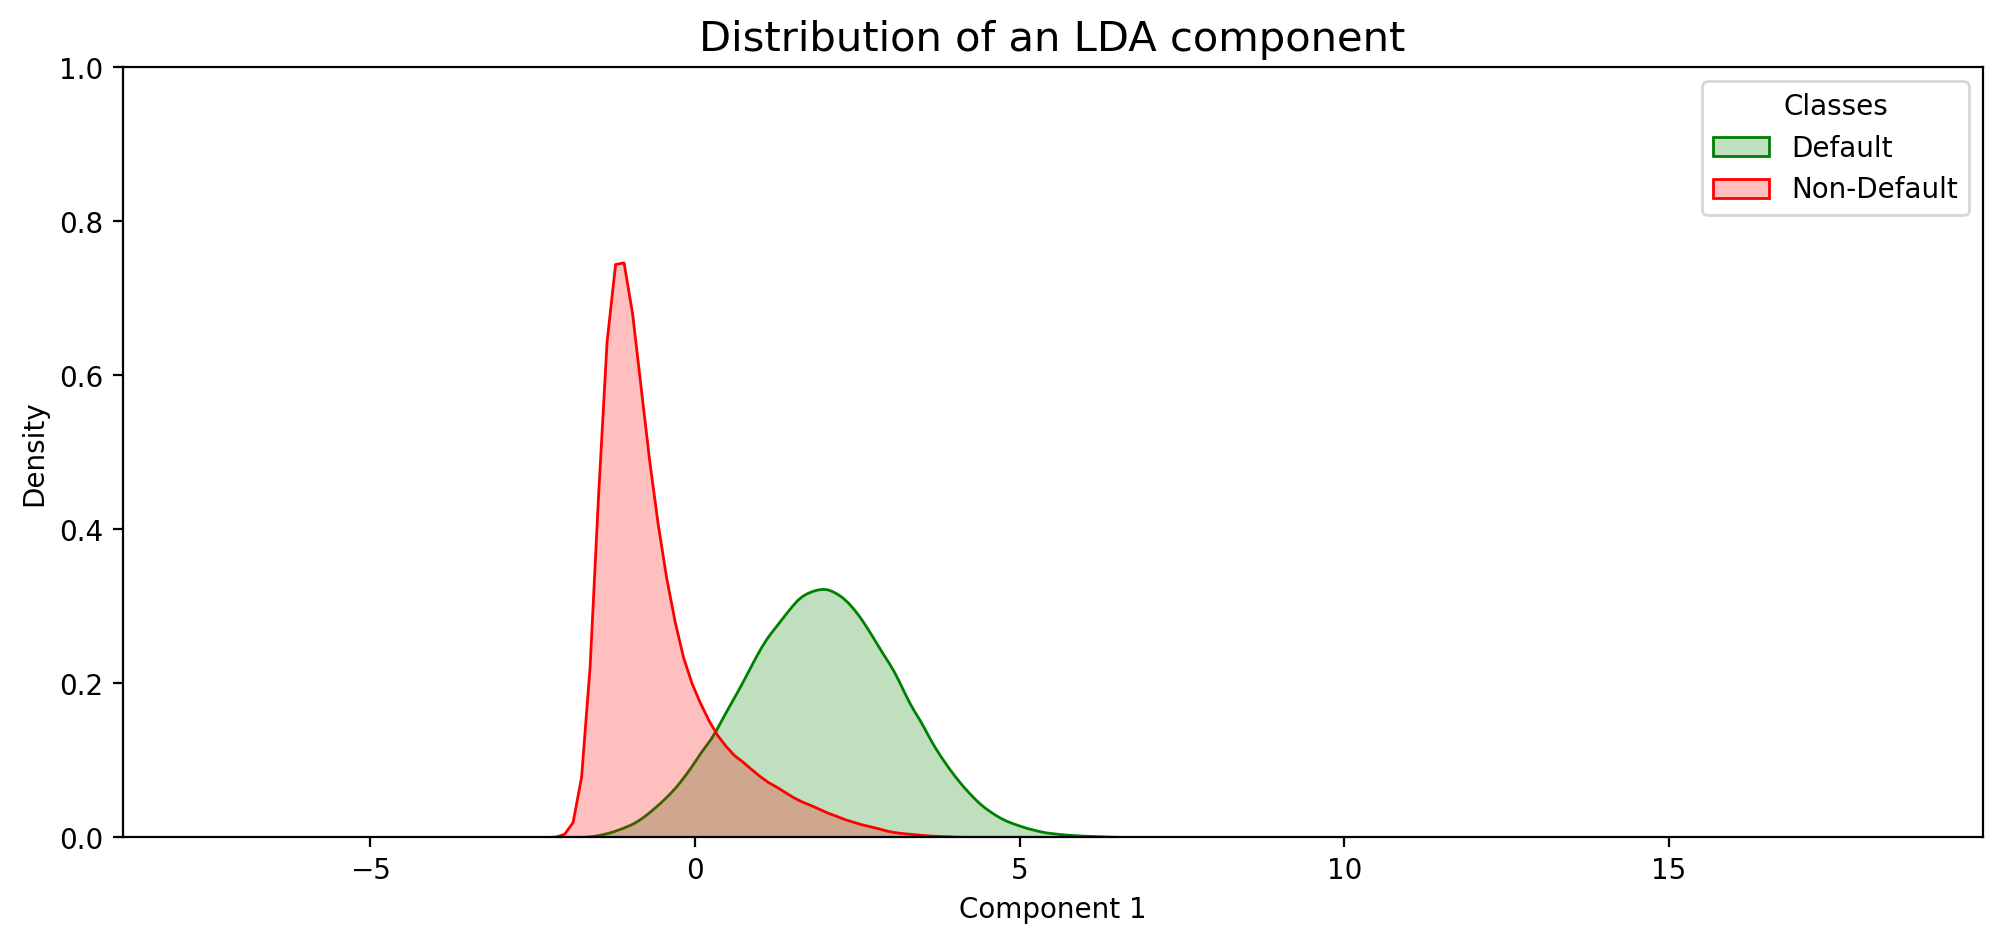

In [17]:
plt.figure(figsize=(12,5))

sns.kdeplot(X_train_lda[:,0][y_train==1], label='Default',
            color='green', fill=True)
sns.kdeplot(X_train_lda[:,0][y_train==0], label='Non-Default',
            color='red', fill=True)

plt.xlabel('Component 1')
plt.ylim([0,1])
plt.title('Distribution of an LDA component',fontsize=15)
plt.legend(title='Classes')
plt.show()

จากกราฟพบว่าอัลกอริทึม Linear Discriminant Analysis สามารถแยก 2 classes ออกจากกันได้ดีพอสมควร

**สรุป:**

ทำการลดมิติด้วย Linear Discriminant Analysis (LDA) จาก 181 features เหลือ 1 component

## 1) Logistic Regression with LDA

In [18]:
import datetime

แสดง timestamp ก่อนรันอัลกอริทึม:

In [19]:
timer_start = datetime.datetime.now()
print(datetime.datetime.now().time())

20:57:41.689319


สร้าง (ฝึกสอน) model:

In [20]:
from sklearn.linear_model import LogisticRegression

logistic_classifier_lda = LogisticRegression(max_iter=1000, random_state=42)
logistic_classifier_lda.fit(X_train_lda, y_train)

LogisticRegression(max_iter=1000, random_state=42)

แสดง timestamp หลังรันอัลกอริทึม:

In [21]:
timer_stop = datetime.datetime.now()
print(datetime.datetime.now().time())

20:57:42.284363


In [22]:
print('The time this algorithm utilised:',timer_stop - timer_start)

The time this algorithm utilised: 0:00:00.595044


**อัลกอริทึมนี้ใช้เวลาทำงานประมาณ 1 วินาที**

สามารถเลือกที่จะบันทึก model ที่จะสร้างใหม่ หรือจะโหลดจาก model ที่สร้างไว้แล้วก็ได้:

In [23]:
# Save Model
joblib.dump(logistic_classifier_lda, './models/Logit_LDA.pkl')

# Load Model
#logistic_classifier_lda = joblib.load('./models/Logit_LDA.pkl')

['./models/Logit_LDA.pkl']

ใช้โมเดลทำนาย test set:

In [24]:
logistic_predicted_lda = logistic_classifier_lda.predict(X_test_lda)

In [25]:
confusion_matrix(y_test, logistic_predicted_lda)

array([[189576,  11681],
       [ 17609,  41458]], dtype=int64)

[ TN FP ]  
[ FN TP ]

TP (ทำนายว่า default; ความจริงคือ default)  
TN (ทำนายว่า non-default; ความจริงคือ non-default)  
FP (ทำนายว่า default; ความจริงคือ non-default)  
FN (ทำนายว่า non-default; ความจริงคือ default)

เรียกฟังก์ชั่นประเมินประสิทธิภาพ model และเก็บค่าไว้ทำกราฟเปรียบเทียบในภายหลัง:

In [26]:
my_eval('Logit_LDA',y_test,logistic_predicted_lda)

Logit_LDA Results
Accuracy:  0.8874863631474624
F1 Score:  0.7389622658324867
Precision:  0.780180281902181
Recall:  0.7018809148932568


## 2) Naïve Bayes with LDA

แสดง timestamp ก่อนรันอัลกอริทึม:

In [27]:
timer_start = datetime.datetime.now()
print(datetime.datetime.now().time())

20:57:42.933922


สร้าง (ฝึกสอน) model:

In [28]:
from sklearn.naive_bayes import GaussianNB

nb_lda = GaussianNB()
nb_lda.fit(X_train_lda, y_train)

GaussianNB()

แสดง timestamp หลังรันอัลกอริทึม:

In [29]:
timer_stop = datetime.datetime.now()
print(datetime.datetime.now().time())

20:57:43.029024


In [30]:
print('The time this algorithm utilised:',timer_stop - timer_start)

The time this algorithm utilised: 0:00:00.095102


**อัลกอริทึมนี้ใช้เวลาทำงานประมาณ 1 วินาที**

สามารถเลือกที่จะบันทึก model ที่จะสร้างใหม่ หรือจะโหลดจาก model ที่สร้างไว้แล้วก็ได้:

In [31]:
# Save Model
joblib.dump(nb_lda, './models/NB_LDA.pkl')

# Load Model
#nb_lda = joblib.load('./models/NB_LDA.pkl')

['./models/NB_LDA.pkl']

ใช้โมเดลทำนาย test set:

In [32]:
nb_predicted_lda = nb_lda.predict(X_test_lda)

In [33]:
confusion_matrix(y_test, nb_predicted_lda)

array([[187656,  13601],
       [ 15288,  43779]], dtype=int64)

เรียกฟังก์ชั่นประเมินประสิทธิภาพ model และเก็บค่าไว้ทำกราฟเปรียบเทียบในภายหลัง:

In [34]:
my_eval('NB_LDA',y_test,nb_predicted_lda)

NB_LDA Results
Accuracy:  0.8890267512791752
F1 Score:  0.7519128874080054
Precision:  0.7629661903102126
Recall:  0.7411752755345624


## 3) Decision Tree with LDA

แสดง timestamp ก่อนรันอัลกอริทึม:

In [35]:
timer_start = datetime.datetime.now()
print(datetime.datetime.now().time())

20:57:43.714639


สร้าง (ฝึกสอน) model:

In [36]:
from sklearn.tree import DecisionTreeClassifier

dtree_lda = DecisionTreeClassifier(random_state=42)
dtree_lda.fit(X_train_lda, y_train)

DecisionTreeClassifier(random_state=42)

แสดง timestamp หลังรันอัลกอริทึม:

In [37]:
timer_stop = datetime.datetime.now()
print(datetime.datetime.now().time())

20:58:01.405662


In [38]:
print('The time this algorithm utilised:',timer_stop - timer_start)

The time this algorithm utilised: 0:00:17.691023


**อัลกอริทึมนี้ใช้เวลาทำงานประมาณ 18 วินาที**

สามารถเลือกที่จะบันทึก model ที่จะสร้างใหม่ หรือจะโหลดจาก model ที่สร้างไว้แล้วก็ได้:

In [39]:
# Save Model
joblib.dump(dtree_lda, './models/DT_LDA.pkl')

# Load Model
#dtree_lda = joblib.load('./models/DT_LDA.pkl')

['./models/DT_LDA.pkl']

ใช้โมเดลทำนาย test set:

In [40]:
dtree_predicted_lda = dtree_lda.predict(X_test_lda)

In [41]:
confusion_matrix(y_test, dtree_predicted_lda)

array([[181196,  20061],
       [ 20541,  38526]], dtype=int64)

เรียกฟังก์ชั่นประเมินประสิทธิภาพ model และเก็บค่าไว้ทำกราฟเปรียบเทียบในภายหลัง:

In [42]:
my_eval('DT_LDA',y_test,dtree_predicted_lda)

DT_LDA Results
Accuracy:  0.8440328206388962
F1 Score:  0.6549033607017185
Precision:  0.6575861539249321
Recall:  0.6522423688353903


## 4) Random Forest with LDA

แสดง timestamp ก่อนรันอัลกอริทึม:

In [43]:
timer_start = datetime.datetime.now()
print(datetime.datetime.now().time())

20:58:02.225447


สร้าง (ฝึกสอน) model:

In [44]:
from sklearn.ensemble import RandomForestClassifier

rf_lda = RandomForestClassifier(n_estimators=100, random_state=42)
rf_lda.fit(X_train_lda, y_train)

RandomForestClassifier(random_state=42)

แสดง timestamp หลังรันอัลกอริทึม:

In [45]:
timer_stop = datetime.datetime.now()
print(datetime.datetime.now().time())

21:15:32.441098


In [46]:
print('The time this algorithm utilised:',timer_stop - timer_start)

The time this algorithm utilised: 0:17:30.215651


**อัลกอริทึมนี้ใช้เวลาทำงานประมาณ 18 นาที**

สามารถเลือกที่จะบันทึก model ที่จะสร้างใหม่ หรือจะโหลดจาก model ที่สร้างไว้แล้วก็ได้:

In [47]:
# Save Model
joblib.dump(rf_lda, './models/RF_LDA.pkl')

# Load Model
#rf_lda = joblib.load('./models/RF_LDA.pkl')

['./models/RF_LDA.pkl']

ใช้โมเดลทำนาย test set:

In [48]:
rf_predicted_lda = rf_lda.predict(X_test_lda)

In [49]:
confusion_matrix(y_test, rf_predicted_lda)

array([[181063,  20194],
       [ 20364,  38703]], dtype=int64)

เรียกฟังก์ชั่นประเมินประสิทธิภาพ model และเก็บค่าไว้ทำกราฟเปรียบเทียบในภายหลัง:

In [50]:
my_eval('RF_LDA',y_test,rf_predicted_lda)

RF_LDA Results
Accuracy:  0.8442018407830242
F1 Score:  0.6561832423451223
Precision:  0.6571302443248382
Recall:  0.6552389659200569


---

In [51]:
display(df_model_compare)

,Logit_LDA,NB_LDA,DT_LDA,RF_LDA
Accuracy,0.887486,0.889027,0.844033,0.844202
F1 Score,0.738962,0.751913,0.654903,0.656183
Precision,0.780180,0.762966,0.657586,0.657130
Recall,0.701881,0.741175,0.652242,0.655239


บันทึกค่าประเมินประสิทธิภาพของแต่ละ model เพื่อใช้เปรียบเทียบใน notebook ชื่อ 5_Comparison.ipynb:

In [52]:
df_model_compare.to_csv('./eval_results/eval_results_LDA.csv')